**Install dependencies**

In [ ]:
# %%capture
# try:
#     import miniai
# except ImportError:
#     !git clone https://github.com/fastai/course22p2.git
#     !pip install -e ./course22p2

In [ ]:
# %%capture
# !pip install torch torchvision torchaudio torcheval
# !pip install numpy pandas pillow wandb
# !pip install cjm_pil_utils cjm_kaggle_utils cjm_pytorch_utils cjm_pandas_utils

**Import dependencies**

In [ ]:
from pathlib import Path
import hashlib
import json
import random
import multiprocessing
import math
import os
from functools import partial
from copy import copy
from glob import glob

from PIL import Image
import numpy as np
import timm
from tqdm.auto import tqdm

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torcheval.tools import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import miniai dependencies
import fastcore.all as fc
from miniai.datasets import DataLoaders
from miniai.conv import def_device
from miniai.learner import *
from miniai.activations import Hook, ActivationStats
from miniai.accel import MixedPrecision, AccelerateCB
from miniai.init import BatchTransformCB, GeneralRelu, init_weights, set_seed, conv
from miniai.sgd import BatchSchedCB
from miniai.resnet import ResBlock

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, tensor_stats_df, get_torch_device, denorm_img_tensor
from cjm_pandas_utils.core import markdown_to_pandas

2023-03-11 11:04:47.029001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 11:04:48.067833: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-11 11:04:50.811104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-11 11:04:50.811201: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

**Set Kaggle username and API token**

In [ ]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [ ]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


**Set directory paths**

In [ ]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


**Set Kaggle dataset**

In [ ]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: /mnt/980_1TB_2/Datasets/hagrid-classification-512p-no-gesture-150k


**Download Kaggle dataset**

In [ ]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

Dataset already downloaded


**Get image classes**

In [ ]:
# Get all subfolders within the dataset_path
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

# Store the folder names
class_names = [f.name for f in folders]

# Print the list of class names
pd.DataFrame(class_names)

,0
0,call
1,dislike
2,fist
3,four
4,like
5,mute
6,no_gesture
7,ok
8,one
9,palm


**Get image paths**

In [ ]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

**Log in to Weights & Biases**

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: millscj. Use `wandb login --relogin` to force relogin


True

**Set random number seed**

In [ ]:
# seed = 1
# seed = 42
# seed = 100
seed = 1234
set_seed(seed)

**Set device and data type**

In [ ]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

**Display sample image**

Class: stop


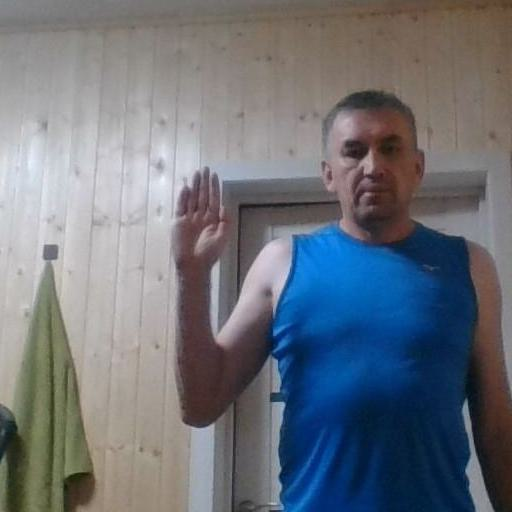

In [ ]:
# Select a random image path from the list of image paths
img_path = random.choice(img_paths)

# Print the name of the class of the image, which is the name of the parent folder
print(f"Class: {img_path.parent.name}")

# Open the image using the path
sample_img = Image.open(img_path)

# Display the image
sample_img

**Random Square Copy Transform**

In [ ]:
def rand_square_copy(img_tensor:torch.Tensor, pct:float):
    """
    Copy data from a randomly selected square region to another randomly selected square region of an image tensor.

    Args:
    img_tensor (torch.Tensor): The input image tensor.
    pct (float): The percentage of the image tensor's size to be used as the side length of the square regions.

    Returns:
    torch.Tensor: The modified input image tensor.
    """
    
    # Get the shape of the tensor
    h, w = img_tensor.shape[-2:]
    
    # Calculate the size of the square
    szx = int(pct * h)
    szy = int(pct * w)
    
    # Calculate the top-left coordinate of the first square
    stx1 = int(random.random() * (1 - pct) * h)
    sty1 = int(random.random() * (1 - pct) * w)
    
    # Calculate the top-left coordinate of the second square
    stx2 = int(random.random() * (1 - pct) * h)
    sty2 = int(random.random() * (1 - pct) * w)
    
    # Copy the data from the second square to the first square
    img_tensor[..., stx1:stx1 + szx, sty1:sty1 + szy] = img_tensor[..., stx2:stx2 + szx, sty2:sty2 + szy]
    
    # Return the modified input img_tensor
    return img_tensor

In [ ]:
class RandSquareCopy(nn.Module):
    def __init__(self, pct=0.2, min_num=0, max_num=4):
        """
        A PyTorch module that applies the `rand_square_copy` function to an input tensor multiple times.

        Args:
        pct (float, optional): The percentage of the tensor's size to be used as the side length of 
                               the square regions.
        min_num (int, optional): The minimum number of times to apply the `rand_square_copy` function.
        max_num (int, optional): The maximum number of times to apply the `rand_square_copy` function.
        """
        super().__init__()
        self.pct = pct
        self.min_num = min_num
        self.max_num = max_num
        
    def forward(self, x): 
        # Apply the `rand_square_copy` function to the input tensor multiple times
        for i in range(random.randint(self.min_num, self.max_num)):
            x = rand_square_copy(x, max(0.1,random.random()*self.pct))
        return x

**Test the transform**

torch.Size([3, 512, 512])


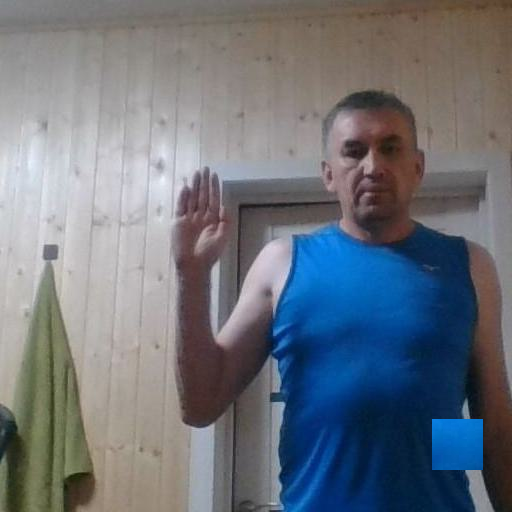

In [ ]:
rand_square_copy_tf = RandSquareCopy(pct=0.2, min_num=1, max_num=1)

# Convert the PIL image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

# Apply the `rand_square_copy_tf` transform to the image tensor
tensor_to_pil(rand_square_copy_tf(img_tensor))

**Random Pixel Copy Transform**

In [ ]:
def rand_pixel_copy(img_tensor:torch.Tensor, pct:float=0.2):
    """
    Copy data from a randomly selected set of pixels to another randomly selected set of pixels of a image tensor.

    Args:
    img_tensor (torch.Tensor): The input image tensor.
    pct (float, optional): The percentage of the total number of pixels to be selected as the source and target sets
                           of pixels.
    
    Returns:
    torch.Tensor: The modified input image tensor.
    """
    
    src_dim = img_tensor.dim()
    
    img_tensor = img_tensor.unsqueeze(0) if src_dim == 3 else img_tensor
    
    # Get the shape of the img_tensor
    b, c, h, w = img_tensor.shape
    
    # Calculate the number of pixels to be selected
    num_pixels = int(img_tensor[-1:].numel() * pct)
    
    # Select the source pixel indices
    source_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
    source_indices[:, 0] = source_indices[:, 0] // w
    source_indices[:, 1] = source_indices[:, 1] % w
    
    # Select the target pixel indices
    target_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
    target_indices[:, 0] = target_indices[:, 0] // w
    target_indices[:, 1] = target_indices[:, 1] % w
    
    # Get the indices of the channels
    c_indices = torch.arange(c).repeat(num_pixels, 1).t()
    
    # Copy the pixels
    source_pixels = img_tensor[:, c_indices, source_indices[:, 0], source_indices[:, 1]]
    img_tensor[:, c_indices, target_indices[:, 0], target_indices[:, 1]] = source_pixels
    
    return img_tensor.squeeze(0) if src_dim == 3 else img_tensor

In [ ]:
class RandPixelCopy(nn.Module):
    def __init__(self, pct=0.1):
        """
        A PyTorch module that applies the `rand_pixel_copy` function to an input tensor.

        Args:
        pct (float, optional): The maximum percentage of the tensor's pixels to be copied.
        """
        super().__init__()
        self.pct = pct
        
    def forward(self, x):
        # Apply the `rand_pixel_copy` function to the input tensor
        return rand_pixel_copy(x, max(0.0025, random.random() * self.pct))

**Test the transform**

torch.Size([3, 512, 512])


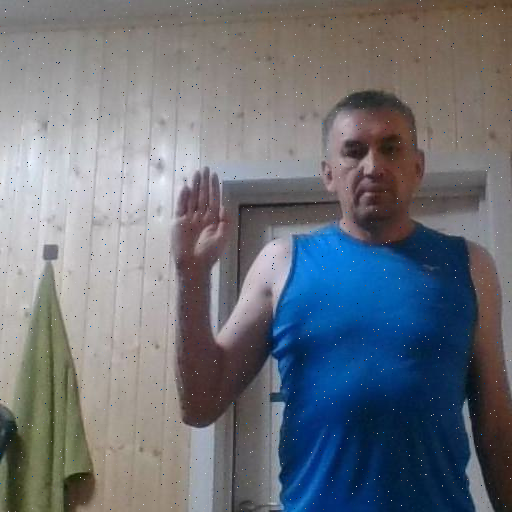

In [ ]:
rand_pixel_copy_tf = RandPixelCopy(pct=0.015)

# Convert the PIL image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

# Apply the `rand_pixel_copy_tf` transform to the image tensor
tensor_to_pil(rand_pixel_copy_tf(img_tensor))

**Random Square Pixel Copy Transform**

In [ ]:
def rand_square_pixel_copy(img_tensor:torch.Tensor, square_pct:float, pixel_pct:float):
    """
    Copy data from a randomly selected set of pixels of a randomly selected square region to another randomly
    selected square region of a tensor.

    Args:
    img_tensor (torch.Tensor): The input tensor.
    square_pct (float): The percentage of the tensor's size to be used as the side length of the square regions.
    pixel_pct (float): The percentage of the pixels of the source square region to be copied.

    Returns:
    torch.Tensor: The modified input tensor.
    """
    # Get the shape of the tensor
    h, w = img_tensor.shape[-2:]
    
    # Calculate the size of the square
    szx = int(square_pct * h)
    szy = int(square_pct * w)
    
    # Calculate the top-left coordinate of the first square
    stx1 = int(random.random() * (1 - square_pct) * h)
    sty1 = int(random.random() * (1 - square_pct) * w)
    
    # Calculate the top-left coordinate of the second square
    stx2 = int(random.random() * (1 - square_pct) * h)
    sty2 = int(random.random() * (1 - square_pct) * w)
    
    # Copy the data from the second square to the first square
    source_pixels = rand_pixel_copy(img_tensor[..., stx2:stx2 + szx, sty2:sty2 + szy].clone(), pixel_pct)
    img_tensor[..., stx1:stx1 + szx, sty1:sty1 + szy] = source_pixels
    
    # Return the modified input tensor
    return img_tensor

In [ ]:
class RandSquarePixelCopy(nn.Module):
    def __init__(self, square_pct=0.2, pixel_pct=1.0, min_num=0, max_num=4):
        """
        A PyTorch module that applies the `rand_square_pixel_copy` function to an input tensor.

        Args:
        square_pct (float, optional): The percentage of the tensor's size to be used as the side length of the
                                      square regions.
        pixel_pct (float, optional): The maximum percentage of the pixels of the source square region to be copied.
        min_num (int, optional): The minimum number of times the `rand_square_pixel_copy` function is applied to
                                 the input tensor.
        max_num (int, optional): The maximum number of times the `rand_square_pixel_copy` function is applied to
                                 the input tensor.
        """
        super().__init__()
        self.square_pct = square_pct
        self.pixel_pct = pixel_pct
        self.min_num = min_num
        self.max_num = max_num
        
    def forward(self, x):
        # Apply the `rand_square_pixel_copy` function to the input tensor
        for i in range(random.randint(self.min_num, self.max_num)):
            x = rand_square_pixel_copy(x, 
                                       max(0.1,random.random()*self.square_pct), 
                                       max(0.0025, random.random()*self.pixel_pct))
        return x

**Test the transform**

torch.Size([3, 512, 512])


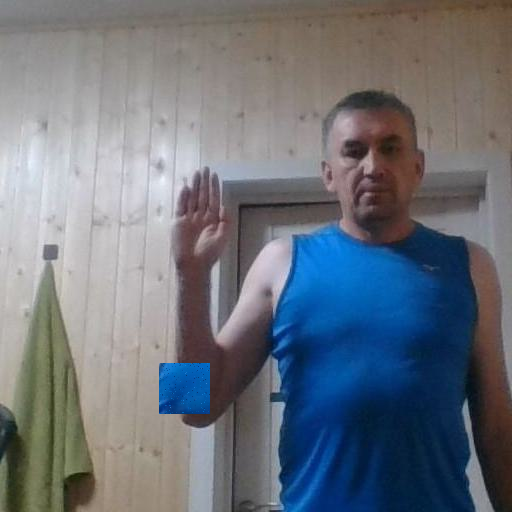

In [ ]:
rand_square_pixel_copy_tf = RandSquarePixelCopy(square_pct=0.2, pixel_pct=1.0, min_num=1, max_num=1)

img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

tensor_to_pil(rand_square_pixel_copy_tf(img_tensor))

**Trivial Augmentation**

torch.Size([1, 3, 512, 512])


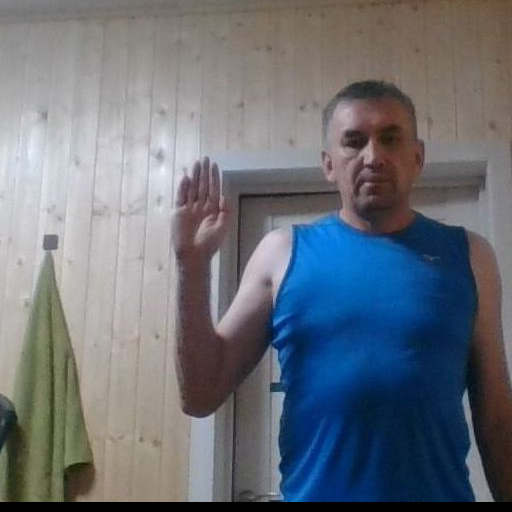

In [ ]:
# Create a TrivialAugmentWide object
trivial_aug = transforms.TrivialAugmentWide()

# Convert the image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)[None]
print(img_tensor.shape)

# Apply the TrivialAugmentWide to the tensor
tensor_to_pil(trivial_aug(img_tensor))

**Custom Trivial Augmentation Transform**

In [ ]:
class CustomTrivAug(nn.Module):
    def __init__(self, aug_list):
        """
        A PyTorch module that applies a random image augmentation.

        Args:
        aug_list (list): List of functions that implement the desired augmentations.
        """
        super().__init__()
        self.aug_list = aug_list
        
    def forward(self, x):
        return random.choice(aug_list)(x)

**Test the transform**

torch.Size([3, 512, 512])


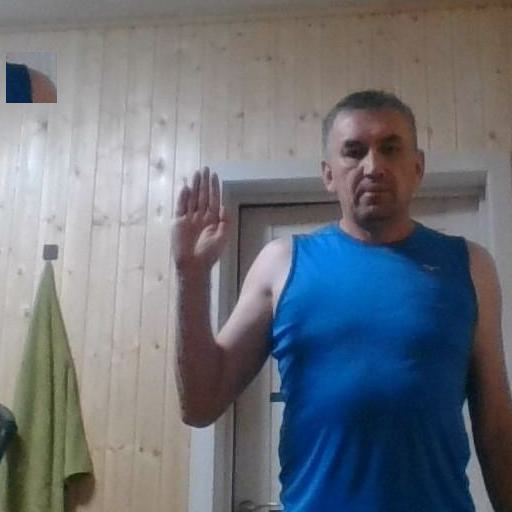

In [ ]:
aug_list = [
    # Identity transformation (no augmentation applied)
    lambda x:x,
    # Random square copy transformation
    rand_square_copy_tf,
    # Random pixel copy transformation
    rand_pixel_copy_tf,
    # Random square pixel copy transformation
    rand_square_pixel_copy_tf
]

# Create an instance of the CustomTrivAug module
custom_triv_aug_tf = CustomTrivAug(aug_list=aug_list)

# Convert a sample image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

# Apply a random augmentation and convert the tensor back to an image
tensor_to_pil(custom_triv_aug_tf(img_tensor))

**List available ResNet18 models**

In [ ]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18
1,resnet18d


**Inspect config for ResNet18 model**

In [ ]:
# Import the resnet module
from timm.models import resnet

# Choose the resnet model
resnet_model = 'resnet18'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(resnet.default_cfgs[resnet_model], orient='index')

,0
url,https://download.pytorch.org/models/resnet18-5c106cde.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.875
interpolation,bilinear
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,conv1
classifier,fc


**Get normalization stats**

In [ ]:
norm_stats = resnet.default_cfgs[resnet_model]['mean'], resnet.default_cfgs[resnet_model]['std']
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

**Load ResNet18 model**

In [ ]:
# Load the resenet model
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device, data type, and name
resnet18 = resnet18.to(device=device, dtype=dtype)
resnet18.device = device
resnet18.name = resnet_model

**Select model**

In [ ]:
model = resnet18

**Get model summary**

In [ ]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,ResNet,11.2 M,11.2 M,44.8 M,2.4 G,4.6 G,"[1, 3, 256, 256]","[1, 19]"
1,Conv2d,9.4 K,9.4 K,37.6 K,154 M,154 M,"[1, 3, 256, 256]","[1, 64, 128, 128]"
7,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
12,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
16,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
21,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
26,Conv2d,73.7 K,73.7 K,294 K,75.5 M,150 M,"[1, 64, 64, 64]","[1, 128, 32, 32]"
31,Conv2d,147 K,147 K,589 K,150 M,301 M,"[1, 128, 32, 32]","[1, 128, 32, 32]"
35,Conv2d,8.2 K,8.2 K,32.8 K,8.4 M,16.8 M,"[1, 64, 64, 64]","[1, 128, 32, 32]"
38,Conv2d,147 K,147 K,589 K,150 M,301 M,"[1, 128, 32, 32]","[1, 128, 32, 32]"


**Get training and validation sets**

In [ ]:
# Shuffle the image paths
random.shuffle(img_paths)

# Define the percentage of the images that should be used for training
train_pct = 0.9
val_pct = 0.1

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_paths)*train_pct)
val_split = int(len(img_paths)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_paths = img_paths[:train_split]
val_paths = img_paths[train_split:]

# Print the number of images in the training and validation sets
len(train_paths), len(val_paths)

(138361, 15374)

**Set training image size**

In [ ]:
train_sz = (288,288)

**Resize Pad Transform**

In [ ]:
class ResizePad(nn.Module):
    def __init__(self, max_sz=256, padding_mode='edge'):
        """
        A PyTorch module that resizes an image tensor and adds padding to make it a square tensor.

        Args:
        max_sz (int, optional): The size of the square tensor.
        padding_mode (str, optional): The padding mode used when adding padding to the tensor.
        """
        super().__init__()
        self.max_sz = max_sz
        self.padding_mode = padding_mode
        
    def forward(self, x):
        # Get the width and height of the image tensor
        w, h = TF.get_image_size(x)
        
        # Resize the image tensor so that its minimum dimension is equal to `max_sz`
        size = int(min(w, h) / (max(w, h) / self.max_sz))
        x = TF.resize(x, size=size)
        
        # Add padding to make the image tensor a square
        w, h = TF.get_image_size(x)
        offset = (self.max_sz - min(w, h)) // 2
        padding = [0, offset] if h < w else [offset, 0]
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode)
        x = TF.resize(x, size=[self.max_sz] * 2)
        
        return x

**Test the transform**

Source image: (512, 512)
Cropped image: (512, 256)
Cropped tensor: torch.Size([1, 3, 256, 512])
Padded tensor: torch.Size([1, 3, 288, 288])


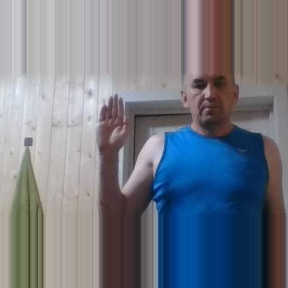

In [ ]:
print(f"Source image: {sample_img.size}")

# Crop the source image
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])
print(f"Cropped image: {cropped_img.size}")

# Create a `ResizePad` object
resize_pad = ResizePad(max_sz=max(train_sz))

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(cropped_img)[None]
print(f"Cropped tensor: {img_tensor.shape}")

# Resize and pad the tensor
resized_tensor = resize_pad(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Apply random pixel copy to the resized and padded tensor
tensor_to_pil(resized_tensor)

**Set image transforms**

In [ ]:
# Set transforms for training set
train_tfms = [
    ResizePad(max_sz=max(train_sz)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
#     rand_square_copy_tf,
#     rand_pixel_copy_tf,
#     rand_square_pixel_copy_tf
#     custom_triv_aug_tf,
]

# Set transforms for validation set
valid_tfms = [
    ResizePad(max_sz=max(train_sz)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
]

**Define training dataset class**

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, classes, tfms):
        # Store the arguments as instance variables
        self.img_paths = img_paths
        self.classes = classes
        self.tfms = tfms
        
        # Create a mapping from class names to class indices
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.img_paths)

    def __getitem__(self, index):
        # Get the path of the image at the given index
        img_path = self.img_paths[index]
        
        # Get the label of the image
        label = self.class_to_idx[img_path.parent.name]
        
        # Open the image
        image = Image.open(img_path).convert('RGB')
        
        return self.tfms(image), label

**Initialize datasets**

In [ ]:
# create the training dataset using the composed transformations
train_dataset = ImageDataset(img_paths=train_paths, 
                             classes=class_names,
                             tfms=transforms.Compose(train_tfms))

# create the validation dataset
valid_dataset = ImageDataset(img_paths=val_paths, 
                             classes=class_names,
                             tfms=transforms.Compose(valid_tfms))

# print the length of the training and validation datasets
len(train_dataset), len(valid_dataset)

(138361, 15374)

**Inspect training set sample**

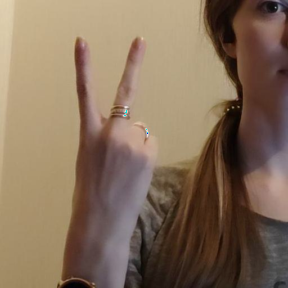

In [ ]:
tensor_to_pil(denorm_img_tensor(train_dataset[0][0], *norm_stats))

**Inspect validation set sample**

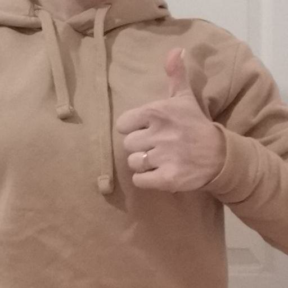

In [ ]:
tensor_to_pil(denorm_img_tensor(valid_dataset[0][0], *norm_stats))

**Set training batch size**

In [ ]:
bs = 32

**Initialzie dataloaders**

In [ ]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=bs, 
                              shuffle=True, 
                              num_workers=multiprocessing.cpu_count())

valid_dataloader = DataLoader(valid_dataset, batch_size=bs)

dls = DataLoaders(train_dataloader, valid_dataloader)

# Print the number of batches in the training and validation dataloaders
len(dls.train), len(dls.valid)

(4324, 481)

**Define training callbacks**

In [ ]:
class OutOfBoundsCB(Callback):
    """
    A callback that exits the training session if the loss is not NaN or infinite.
    """
    def __init__(self, msg="Loss out of bounds"):
        fc.store_attr()
        
    def after_loss(self, learn):
        """
        Check if the loss is NaN or infinite.
        """
        if learn.loss.detach().isnan() or learn.loss.detach().isinf(): 
            print(self.msg)
            raise CancelFitException()

**Initialize callbacks**

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())

cbs = [MixedPrecision(), 
       OutOfBoundsCB(),
       DeviceCB(), 
       metrics, 
       ProgressCB(plot=False),
      ]

**Set optimizer**

In [ ]:
opt_func = partial(torch.optim.AdamW, eps=1e-5)

**Set learning rate scheduler**

In [ ]:
lr = 1e-3
epochs = 3

tmax = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs.append(BatchSchedCB(sched))

**Configure Weights & Biases project**

In [ ]:
project_name = f"miniai_data_augmentation_seed-{seed}"
# run_name = "baseline"
# run_name = "rand-square-cp-1"
# run_name = "rand-pixel-cp-1"
# run_name = "rand-square-pixel-cp-1"
run_name = "trivial-aug-item-1"
# run_name = "custom-trivial-aug-1"

**Initialize learner**

In [ ]:
learn = TrainLearner(model, dls, torch.nn.functional.cross_entropy, lr=lr, cbs=cbs, opt_func=opt_func)

**Train model**

In [ ]:
learn.fit(epochs)

accuracy,loss,epoch,train
0.846,0.534,0,train
0.930,0.221,0,eval
0.914,0.283,1,train
0.986,0.047,1,eval
0.964,0.113,2,train
0.993,0.022,2,eval


**Set checkpoint directory**

In [ ]:
# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(f"./{project_name}/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Print the checkpoint path
checkpoint_dir

Path('miniai_data_augmentation_seed-1234')

**Save model checkpoint**

In [ ]:
torch.save(learn.model.state_dict(), checkpoint_dir/f"{model.name}-{run_name}.pth")

**Test model**

Class: palm
Predicted Class: palm


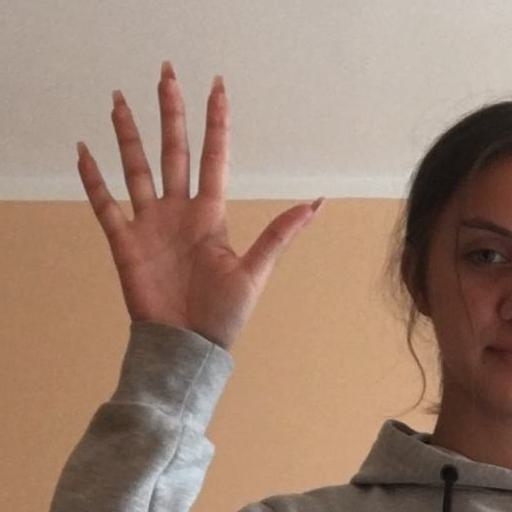

In [ ]:
infer_sz = max(train_sz)

# Choose a random image from the list of image paths
img_path = random.choice(img_paths)

# Print the actual class of the chosen image
print(f"Class: {img_path.parent.name}")

# Open the image and resize it
sample_img = Image.open(img_path)
inp_img = resize_img(sample_img.copy(), infer_sz)

# Convert the image to a tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = learn.model(img_tensor)

# Get the predicted class index and convert it to the class name
pred_class = train_dataset.classes[torch.argmax(torch.softmax(pred, dim=1))]

# Print the predicted class
print(f"Predicted Class: {pred_class}")

# Display the image
sample_img